# MARKET

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class TradingBatched:
    def __init__(self, batch_size, num_assets, num_agents, num_steps):
        self.b = batch_size
        self.num_assets = num_assets
        self.num_agents = num_agents
        self.num_steps  = num_steps
        
    def reset(self):
        
        self.true_values = 5.0 * torch.normal(mean=0, std=1, size=(self.b, self.num_assets)).to(device) # N(0, 1)
        self.stds = 3.0 * torch.sigmoid(torch.normal(mean=0, std=1, size=(self.b, self.num_agents, self.num_assets))).to(device) # N(0, 1)
        self.estimates = torch.normal(mean=self.true_values.unsqueeze(1), std=self.stds).to(device)
        
        self.cash = torch.zeros(self.b, self.num_agents).to(device)
        self.cur_alloc = torch.ones(self.b, self.num_agents, self.num_assets).to(device) * 10000 # everyone just starts w/ one of everythign
        
        self.order_book = torch.zeros(self.b, self.num_agents, self.num_assets, 4).to(device) # TODO: Attention over assets?
        self.t = 0
        
        return self._naive_states()
    
    def _naive_states(self):
        states = []
        for i in range(self.num_agents):
#             order_book = self.order_book.clone()
            
            # TODO: DO THIS CORRECTLY?
#             order_book[:,0], order_book[:,i] = order_book[:,i], order_book[:,0] # AGENT ALWAYS FIRST
            states.append(torch.cat([
                self.order_book.flatten(start_dim=1),
                self.cash[:,i].unsqueeze(-1),
                self.cur_alloc[:,i],
                self.estimates[:,i],
                self.stds[:,i],
            ], dim=-1))

        return states
    
    def step(self, actions_bna4, debug=False):
        
        self.order_book = actions_bna4.clone()
        
        # PRIORIY BASED ON BIDDING
        curr_order_book = actions_bna4.clone()
        
        # CANT SELL MORE THAN YOU HAVE. I DONT CARE IF YOU GET MORE OVER THE COURSE OF TRADING.
        curr_order_book[:,:,:,3] = torch.min(curr_order_book[:,:,:,3], self.cur_alloc)
        
        info = []
#         agent_indices = torch.arange(self.num_agents).repeat_interleave(self.num_assets).view(1,self.num_agents,self.num_assets,1).repeat(self.b,1,1,1).to(device)
#         curr_order_book = torch.cat([curr_order_book, agent_indices], dim=-1)
        

#         curr_order_book = torch.cat([curr_order_book, torch.arange(self.num_agents).repeat_interleave(self.num_assets)[None,None,None,:]], dim=-1)
#         bids_indices_sorted = torch.argsort(curr_order_book[])
        
        while True:
            # REMOVE EMPTY VOLUME. 
            # REMOVE SELF TRADES
            
            # LATER THIS SHOULDNT BE NEEDED
            curr_order_book[:,:,:,2:] = torch.round(curr_order_book[:,:,:,2:])

            # TODO: THIS DOESNT WORK. COULD WE DO IT A BETTER WAY?
#             curr_order_book[curr_order_book[:,:,:,2] <= 0][:,0] = torch.FloatTensor([float("Inf")]).to(device) 
#             curr_order_book[curr_order_book[:,:,:,3] <= 0][:,1] = torch.FloatTensor([float("Inf")]).to(device)

            # WORKS BUT IS PITA
#             curr_order_book[curr_order_book[:,:,:,2] <= 0] = torch.cat([-float("Inf") + torch.zeros_like(curr_order_book[curr_order_book[:,:,:,2] <= 0][:,0:1]), curr_order_book[curr_order_book[:,:,:,2] <= 0][:,1:]],dim=-1)


            tmp = curr_order_book[curr_order_book[:,:,:,2] <= 0]
            tmp[:,0] = -float("Inf")
            curr_order_book[curr_order_book[:,:,:,2] <= 0] = tmp
            
            tmp = curr_order_book[curr_order_book[:,:,:,3] <= 0]
            tmp[:,1] = float("Inf")
            curr_order_book[curr_order_book[:,:,:,3] <= 0] = tmp

#             can trade with self i guess
#             curr_order_book[curr_order_book[:,:,:,0] > curr_order_book[:,:,:,1]] = torch.FloatTensor([-float("Inf"), float("Inf"), 0, 0]).to(device)

            max_bids = torch.max(curr_order_book[:,:,:,0], dim=1)
            highest_bidders, highest_bids_ba = max_bids.indices, max_bids.values
            
            h_ind = highest_bidders.unsqueeze(1).unsqueeze(-1).repeat(1,1,1,4)
            highest_row = torch.gather(curr_order_book, 1, h_ind).squeeze(1)
        
            min_asks = torch.min(curr_order_book[:,:,:,1], dim=1)
            lowest_askers, lowest_asks_ba = min_asks.indices, min_asks.values

            l_ind = lowest_askers.unsqueeze(1).unsqueeze(-1).repeat(1,1,1,4)
            lowest_row = torch.gather(curr_order_book, 1, l_ind).squeeze(1)
            
            # Break if all lowest asks are higher than all highest bids across all batches and assets
            if torch.all(highest_bids_ba < lowest_asks_ba) or torch.all(lowest_row[:,:,3] <= 0) or torch.all(highest_row[:,:,2] <= 0):
                break
            
            num_trades = torch.where(
                lowest_asks_ba <= highest_bids_ba, 
                torch.min(highest_row[:,:,2], lowest_row[:,:,3]),
                torch.zeros_like(highest_row[:,:,2])
            )

            
            # TODO: CLEAN. I DONT EVEN KNOW IF THIS IS CORRECT.
            # APPARENTLY BUYER BUYS AT OWN PRICE
#             cash_diff = torch.nan_to_num(num_trades * lowest_asks_ba).unsqueeze(-1)
            cash_diff = torch.nan_to_num(num_trades * highest_bids_ba).unsqueeze(-1)

            highest_cash_diff = torch.zeros_like(self.cash.unsqueeze(1).repeat(1,self.num_assets,1)).scatter_(-1,highest_bidders.unsqueeze(-1),cash_diff).sum(1)
            lowest_cash_diff = torch.zeros_like(self.cash.unsqueeze(1).repeat(1,self.num_assets,1)).scatter_(-1,lowest_askers.unsqueeze(-1),cash_diff).sum(1)
            self.cash -= highest_cash_diff
            self.cash += lowest_cash_diff
            
            # TODO: CLEAN
            highest_alloc_diff = torch.zeros_like(self.cur_alloc).scatter_(1, highest_bidders.unsqueeze(1).repeat(1,self.num_agents,1), num_trades.unsqueeze(1).repeat(1,self.num_agents,1))
            lowest_alloc_diff = torch.zeros_like(self.cur_alloc).scatter_(1, lowest_askers.unsqueeze(1).repeat(1,self.num_agents,1), num_trades.unsqueeze(1).repeat(1,self.num_agents,1))
            self.cur_alloc += highest_alloc_diff
            self.cur_alloc -= lowest_alloc_diff
            
            
            curr_order_book[:,:,:,2].scatter_(1, h_ind[:,:,:,0], -num_trades.unsqueeze(1), reduce='add')
            curr_order_book[:,:,:,3].scatter_(1, l_ind[:,:,:,0], -num_trades.unsqueeze(1), reduce='add')
            if debug:
                info.append(
                    {
                        "num_trades": num_trades,
                        "lowest_asks": lowest_asks_ba,
                        "cash_diff": cash_diff,
                        "highest_alloc_diff": highest_alloc_diff,
                        "lowest_alloc_diff": lowest_alloc_diff,
                        "curr_order_book": curr_order_book.clone()
                    }
                )

        self.t += 1
        if self.t == self.num_steps:
            reward = (self.true_values.unsqueeze(1) * self.cur_alloc).sum(dim=-1) + self.cash
        else:
            reward = torch.zeros(self.b, self.num_agents).to(device)
        
        return self._naive_states(), reward, info


In [7]:
env = TradingBatched(3, 2, 2, 8)

In [9]:
asdf = env.reset()
for _ in range(8):
    order_book = torch.cat([torch.normal(mean=0.0,std=1.0,size=(3,2,2,2)), torch.randint(0,5,[3,2,2,2])], dim=-1).to(device)
    _, r, _ = env.step(order_book)
    print(r)
    

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')
tensor([[ 103998.7266,  104000.4141],
        [-252608.1562, -252647.0938],
        [ 115266.1484,  115228.2422]], device='cuda:0')


In [11]:
from torch.distributions import OneHotCategorical
import numpy as np

from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt


class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std, initialization=False):
        super(ActorCritic, self).__init__()
        # action mean range -1 to 1
        self.actor =  nn.Sequential(
                nn.Linear(state_dim, 256),
                nn.Tanh(),
#                 nn.Linear(128, 128),
#                 nn.Tanh(),
                nn.Linear(256, action_dim * 2),
# #                 nn.Tanh()
                )
        
        
        
        # critic
        self.critic = nn.Sequential(
                nn.Linear(state_dim, 256),
                nn.Tanh(),
#                 nn.Linear(128, 128),
#                 nn.Tanh(),
                nn.Linear(256, 1),
                )
        self.action_dim = action_dim
        self.state_dim = state_dim

        self.init_var = torch.full((action_dim,), action_std*action_std).to(device)
#         self.init_std = action_std

    def forward(self):
        raise NotImplementedError

    def act(self, state, memory):
        if state.sum() < 0:
#             if self.initialization:
#                 action_mean = self.initial_policy.repeat(state.shape[0], 1)
#             else:
            action_mean = torch.zeros(state.shape[0], self.action_dim).to(device)
            cov_mat = torch.diag(self.init_var)
        else:
#             import pdb; pdb.set_trace()
            action_mean, action_var = torch.split(self.actor(state), action_dim, dim=-1)
            cov_mat = torch.diag_embed(F.softplus(action_var))

        dist = MultivariateNormal(action_mean, cov_mat)

        action = dist.sample()
        action_logprob = dist.log_prob(action)

        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(action_logprob)

        return action.detach()

    def evaluate(self, state, action):         
        action_mean, action_var = torch.split(self.actor(state), action_dim, dim=-1)
        action_var = F.softplus(action_var)
            
        # NO GRADIENT FOR THE INITIAL STATE
        action_mean = torch.where(state.sum((1,2),keepdim=True) < 0, torch.zeros_like(action_mean), action_mean)
        action_var = torch.where(state.sum((1,2),keepdim=True) < 0, torch.ones_like(action_var) * 0.5, action_var)
        
#         action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var).to(device)

        dist = MultivariateNormal(action_mean, cov_mat)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        state_value = self.critic(state)
        state_value = torch.where(state.sum((1,2),keepdim=True) < 0, torch.zeros_like(state_value), state_value)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

class PPO:
    def __init__(self, state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.policy = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)

        self.policy_old = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        

        self.MseLoss = nn.MSELoss()

    def select_action(self, state, memory):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy_old.act(state, memory).cpu().data.numpy().flatten()

    def update(self, memory):
        # Monte Carlo estimate of rewards:
        rewards = []
        discounted_reward = 0
        for reward in reversed(memory.rewards):
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards:
#         rewards = torch.stack(rewards, dtype=torch.float32).to(device)
        rewards = torch.stack(rewards).squeeze(-1)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # convert list to tensor
        old_states = torch.stack(memory.states).detach()
        old_actions = torch.stack(memory.actions).detach()
        old_logprobs = torch.stack(memory.logprobs).detach()

        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())




In [2]:
############################################

num_assets=2
num_agents=2
num_steps=8

state_dim = num_assets * num_agents * 4 + num_assets * 3 + 1
# FLATTENED ORDER BOOK + CURRENT ALLOC/ESTIAMTE/VARIANCE + CASH

action_dim = num_assets * 4
# ORDER BOOK

action_std = 0.5 # constant std for action distribution (Multivariate Normal)
# K_epochs = 80               # update policy for K epochs
K_epochs = 4               # update policy for K epochs

eps_clip = 0.2              # clip parameter for PPO
gamma = 0.95                # discount factor

lr = 0.0002                 # parameters for Adam optimizer
betas = (0.9, 0.999)


max_episodes = 10000
batch_size = 50000
random_seed = None
# num_steps = 100
#############################################

# creating environment
env = TradingBatched(batch_size, num_assets, num_agents, num_steps)

memory = [Memory() for _ in range(num_agents)]
ppo = [PPO(state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip) for _ in range(num_agents)]

print(lr,betas)

# training loop

for i_episode in range(1, max_episodes+1):
    state = env.reset()
    
    running_rewards = torch.zeros(batch_size, num_agents).to(device)
    
    last_reward = 0
    
    for t in range(num_steps):

        # Running policy_old:
        asdf = []
        for i in range(num_agents):
            asdf.append(ppo[i].policy_old.act(state[i], memory[i]))
        
        actions = torch.stack([torch.stack(a.split(2, dim=-1),dim=-1) for a in asdf], dim=1)
        state, reward, _ = env.step(actions)
        running_rewards += reward

        for i in range(num_agents):
            memory[i].rewards.append(reward[:,i])

    ppo[0].update(memory[0])

    for i in range(num_agents):
        memory[i].clear_memory()
        
    print("="*100)
    
    print(f"p0 reward: {running_rewards[:,0].mean()}")
    



0.0002 (0.9, 0.999)
p0 reward: 69.67228698730469
p0 reward: 638.2947998046875
p0 reward: 525.2352905273438
p0 reward: 37.2098388671875
p0 reward: -91.80204010009766
p0 reward: -556.6376953125
p0 reward: -245.86444091796875
p0 reward: -345.2394714355469
p0 reward: -456.9969482421875
p0 reward: -321.96588134765625
p0 reward: 82.23880767822266
p0 reward: 97.52543640136719
p0 reward: 471.89752197265625
p0 reward: -174.44322204589844
p0 reward: 345.3282775878906
p0 reward: 118.52265930175781
p0 reward: -156.521240234375
p0 reward: -759.7158813476562
p0 reward: -235.6131134033203


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/data/engs-multi-agent-learning/exet5589/myenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1333155/2095127547.py", line 61, in <module>
    ppo[0].update(memory[0])
  File "/tmp/ipykernel_1333155/1372387200.py", line 153, in update
    loss.mean().backward()
  File "/data/engs-multi-agent-learning/exet5589/myenv/lib/python3.8/site-packages/torch/_tensor.py", line 307, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/data/engs-multi-agent-learning/exet5589/myenv/lib/python3.8/site-packages/torch/autograd/__init__.py", line 154, in backward
    Variable._execution_engine.run_backward(
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/data/engs-multi-agent-learning/exet5589/myenv/lib/python3


KeyboardInterrupt



In [125]:
b = 9348
print(state[0][b,-6:-4])
print(state[0][b,-4:])
print(actions[b])

tensor([2., 1.], device='cuda:0')
tensor([11.5655, -0.6388,  5.8381,  2.0847], device='cuda:0')
tensor([[[ 0.6745,  2.2489,  2.6252, -3.0702],
         [ 0.3061,  0.6118,  3.1051,  1.7450]],

        [[ 1.1132,  0.0641,  0.8648,  0.8373],
         [ 0.4544,  0.8206, -0.6243, -0.1486]]], device='cuda:0')


# FIGGIE

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FiggieBatched:
    def __init__(self, batch_size, num_steps):
        self.b = batch_size
        self.num_assets = 4
        self.num_agents = 4
        self.num_steps = num_steps
        
    def reset(self):
        self.suit_shuff = torch.argsort(torch.rand((self.b,4)), dim=-1).to(device)
        cards = torch.cat([
            self.suit_shuff[:,0:1] * torch.ones((self.b, 12)).to(device),
            self.suit_shuff[:,1:2] * torch.ones((self.b, 8)).to(device),
            self.suit_shuff[:,2:3] * torch.ones((self.b, 10)).to(device),
            self.suit_shuff[:,3:4] * torch.ones((self.b, 10)).to(device),
        ], dim=-1)
        cards = cards[torch.arange(self.b).unsqueeze(-1), torch.argsort(torch.rand((self.b,40)), dim=-1)]
        hands = cards.split(10,dim=-1)
        self.cur_alloc = torch.stack([
             torch.stack([
                (hands[j]==i).sum(dim=-1)        
            for j in range(4)])
        for i in range(4)]).swapaxes(0,2).to(device).float() # TODO: THIS SHOULDNT BE FLOAT
        self.goal_suit = (self.suit_shuff[:,0] + 2) % 4
        self.bonus = torch.where(self.goal_suit == self.suit_shuff[:,1], 120.0, 100.0).to(device)
        
        self.cash = torch.zeros(self.b, self.num_agents).to(device)
#         self.cur_alloc = torch.ones(self.b, self.num_agents, self.num_assets).to(device) # everyone just starts w/ one of everythign
        
        self.order_book = torch.zeros(self.b, self.num_agents, self.num_assets, 4).to(device) # TODO: Attention over assets?
        self.t = 0
        
        return self._naive_states()
    
    def _naive_states(self):
        states = []
        for i in range(self.num_agents):
            states.append(torch.cat([
                self.order_book.flatten(start_dim=1),
                self.cash[:,i].unsqueeze(-1),
                self.cur_alloc[:,i],
            ], dim=-1))

        return states
    
    def step(self, actions_bna4, debug=False):
        
        self.order_book = actions_bna4.clone()
        
        # PRIORIY BASED ON BIDDING
        curr_order_book = actions_bna4.clone()
        
        # CANT SELL MORE THAN YOU HAVE. I DONT CARE IF YOU GET MORE OVER THE COURSE OF TRADING.
        curr_order_book[:,:,:,3] = torch.min(curr_order_book[:,:,:,3], self.cur_alloc)
        
        info = []
        
        while True:
            # REMOVE EMPTY VOLUME. 
            # REMOVE SELF TRADES
            
            
            # LATER THIS SHOULDNT BE NEEDED
            curr_order_book[:,:,:,2:] = torch.round(curr_order_book[:,:,:,2:])

            # TODO: THIS DOESNT WORK. COULD WE DO IT A BETTER WAY?
#             curr_order_book[curr_order_book[:,:,:,2] <= 0][:,0] = torch.FloatTensor([float("Inf")]).to(device) 
#             curr_order_book[curr_order_book[:,:,:,3] <= 0][:,1] = torch.FloatTensor([float("Inf")]).to(device)

            # WORKS BUT IS PITA
#             curr_order_book[curr_order_book[:,:,:,2] <= 0] = torch.cat([-float("Inf") + torch.zeros_like(curr_order_book[curr_order_book[:,:,:,2] <= 0][:,0:1]), curr_order_book[curr_order_book[:,:,:,2] <= 0][:,1:]],dim=-1)


            tmp = curr_order_book[curr_order_book[:,:,:,2] <= 0]
            tmp[:,0] = -float("Inf")
            curr_order_book[curr_order_book[:,:,:,2] <= 0] = tmp
            
            tmp = curr_order_book[curr_order_book[:,:,:,3] <= 0]
            tmp[:,1] = float("Inf")
            curr_order_book[curr_order_book[:,:,:,3] <= 0] = tmp

#             can trade with self i guess
#             curr_order_book[curr_order_book[:,:,:,0] > curr_order_book[:,:,:,1]] = torch.FloatTensor([-float("Inf"), float("Inf"), 0, 0]).to(device)

            max_bids = torch.max(curr_order_book[:,:,:,0], dim=1)
            highest_bidders, highest_bids_ba = max_bids.indices, max_bids.values
            
            h_ind = highest_bidders.unsqueeze(1).unsqueeze(-1).repeat(1,1,1,4)
            highest_row = torch.gather(curr_order_book, 1, h_ind).squeeze(1)
        
            min_asks = torch.min(curr_order_book[:,:,:,1], dim=1)
            lowest_askers, lowest_asks_ba = min_asks.indices, min_asks.values

            l_ind = lowest_askers.unsqueeze(1).unsqueeze(-1).repeat(1,1,1,4)
            lowest_row = torch.gather(curr_order_book, 1, l_ind).squeeze(1)
            
            # Break if all lowest asks are higher than all highest bids across all batches and assets
            if torch.all(highest_bids_ba < lowest_asks_ba) or torch.all(lowest_row[:,:,3] <= 0) or torch.all(highest_row[:,:,2] <= 0):
                break
            
            num_trades = torch.where(
                lowest_asks_ba < highest_bids_ba, 
                torch.min(highest_row[:,:,2], lowest_row[:,:,3]),
                torch.zeros_like(highest_row[:,:,2])
            )

            
            # TODO: CLEAN. I DONT EVEN KNOW IF THIS IS CORRECT.
            # APPARENTLY BUYER BUYS AT OWN PRICE
#             cash_diff = torch.nan_to_num(num_trades * lowest_asks_ba).unsqueeze(-1)
            cash_diff = torch.nan_to_num(num_trades * highest_bids_ba).unsqueeze(-1)

            highest_cash_diff = torch.zeros_like(self.cash.unsqueeze(1).repeat(1,self.num_assets,1)).scatter_(-1,highest_bidders.unsqueeze(-1),cash_diff).sum(1)
            lowest_cash_diff = torch.zeros_like(self.cash.unsqueeze(1).repeat(1,self.num_assets,1)).scatter_(-1,lowest_askers.unsqueeze(-1),cash_diff).sum(1)
            self.cash -= highest_cash_diff
            self.cash += lowest_cash_diff
            
            # TODO: CLEAN
            highest_alloc_diff = torch.zeros_like(self.cur_alloc).scatter_(1, highest_bidders.unsqueeze(1).repeat(1,self.num_agents,1), num_trades.unsqueeze(1).repeat(1,self.num_agents,1))
            lowest_alloc_diff = torch.zeros_like(self.cur_alloc).scatter_(1, lowest_askers.unsqueeze(1).repeat(1,self.num_agents,1), num_trades.unsqueeze(1).repeat(1,self.num_agents,1))
            self.cur_alloc += highest_alloc_diff
            self.cur_alloc -= lowest_alloc_diff
            
            
            curr_order_book[:,:,:,2].scatter_(1, h_ind[:,:,:,0], -num_trades.unsqueeze(1), reduce='add')
            curr_order_book[:,:,:,3].scatter_(1, l_ind[:,:,:,0], -num_trades.unsqueeze(1), reduce='add')

            if debug:
                info.append(
                    {
                        "num_trades": num_trades,
                        "lowest_asks": lowest_asks_ba,
                        "cash_diff": cash_diff,
                        "highest_alloc_diff": highest_alloc_diff,
                        "lowest_alloc_diff": lowest_alloc_diff,
                        "curr_order_book": curr_order_book.clone()
                    }
                )
        self.t += 1
        if self.t == self.num_steps:
#             reward = self.cur_alloc[:,self.goal_suit] * 10.0 + self.cash - 50.0
            num_goal_cards = torch.gather(self.cur_alloc,-1, self.goal_suit.unsqueeze(-1).unsqueeze(-1).repeat(1,4,1)).squeeze(-1)
            reward = num_goal_cards * 10.0 + self.cash - 50.0
            maxvals, _ = torch.max(num_goal_cards, dim=-1)
            reward = reward + torch.where(
                num_goal_cards == maxvals.unsqueeze(-1),
                self.bonus.unsqueeze(-1) / (num_goal_cards == maxvals.unsqueeze(-1)).sum(dim=-1).unsqueeze(-1),
                torch.zeros_like(num_goal_cards)
            )
#             bonus = 
#             reward = (self.true_values.unsqueeze(1) * self.cur_alloc).sum(dim=-1) + self.cash - 50.0
        else:
            reward = torch.zeros(self.b, self.num_agents).to(device)
        
        return self._naive_states(), reward, info


In [40]:
env = FiggieBatched(3, 4)

In [41]:
asdf = env.reset()
for i in range(4):
    order_book = torch.cat([torch.normal(mean=0.0,std=1.0,size=(3,4,4,2)), torch.randint(0,5,[3,4,4,2])], dim=-1).to(device)
    _, r, _ = env.step(order_book)
    if i == 3:
        print(r)
        print(r.sum(-1))
    

tensor([[-40.5816, 123.9113, -41.3803, -41.9494],
        [-49.5777, -23.9371, 113.8453, -40.3306],
        [-18.5984, -43.2542,  97.8560, -36.0034]], device='cuda:0')
tensor([0.0000e+00, 0.0000e+00, 7.6294e-06], device='cuda:0')


In [71]:
############################################

num_assets=4
num_agents=4
num_steps=16

state_dim = num_assets * num_agents * 4 + num_assets + 1
# FLATTENED ORDER BOOK + CURRENT ALLOC + CASH

action_dim = num_assets * 4
# ORDER BOOK

action_std = 0.5 # constant std for action distribution (Multivariate Normal)
# K_epochs = 80               # update policy for K epochs
K_epochs = 4               # update policy for K epochs

eps_clip = 0.2              # clip parameter for PPO
gamma = 0.95                # discount factor

lr = 0.0002                 # parameters for Adam optimizer
betas = (0.9, 0.999)


max_episodes = 10000
batch_size = 8000
random_seed = None
# num_steps = 100
#############################################

# creating environment
env = FiggieBatched(batch_size, num_steps)

memory = [Memory() for _ in range(num_agents)]
ppo = [PPO(state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip) for _ in range(num_agents)]

print(lr,betas)

# training loop

for i_episode in range(1, max_episodes+1):
    state = env.reset()
    print(env.cur_alloc[0])

    running_rewards = torch.zeros(batch_size, num_agents).to(device)
    
    last_reward = 0
    
    for t in range(num_steps):

        # Running policy_old:
        asdf = []
        for i in range(num_agents):
            asdf.append(ppo[i].policy_old.act(state[i], memory[i]))
        

        actions = torch.stack([torch.stack(a.split(num_assets, dim=-1),dim=-1) for a in asdf], dim=1)
        state, reward, _ = env.step(actions)
        running_rewards += reward

        for i in range(num_agents):
            memory[i].rewards.append(reward[:,i])

    print(env.cur_alloc[0])
    print(env.goal_suit[0])
    print(env.suit_shuff[0,0])
    print("*"*5)
    print(torch.gather(env.order_book, 2, env.goal_suit[:,None,None,None].repeat(1,4,1,4)).squeeze(2)[:,:,0].mean())
    print(torch.gather(env.order_book, 2, env.suit_shuff[:,0:1,None,None].repeat(1,4,1,4)).squeeze(2)[:,:,0].mean())

#     print(env.order_book[:,:,env.goal_suit,0].mean())
#     print(env.order_book[:,:,env.suit_shuff[:,0],0].mean())

#     print((env.order_book[0,:,env.goal_suit[0].item(),:].mean(dim=-1))
#     print(env.order_book[0,:,env.goal_suit[0].item(),:])
#     print(env.order_book[0,:,env.suit_shuff[0,0].item(),:])

    for i in range(num_agents):
        ppo[i].update(memory[i])
        memory[i].clear_memory()
        
    for i in range(num_agents):
        print(f"p{i} reward: {running_rewards[:,i].mean()}")
    print("="*100)




0.0002 (0.9, 0.999)
tensor([[0., 2., 2., 6.],
        [4., 1., 3., 2.],
        [3., 3., 2., 2.],
        [3., 2., 3., 2.]], device='cuda:0')
tensor([[2., 2., 6., 5.],
        [3., 2., 1., 1.],
        [3., 0., 1., 3.],
        [2., 4., 2., 3.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor(3, device='cuda:0')
*****
tensor(-0.0344, device='cuda:0')
tensor(-0.0303, device='cuda:0')
p0 reward: 9.06660270690918
p1 reward: -1.2037676572799683
p2 reward: -13.09607219696045
p3 reward: 5.233236789703369
tensor([[3., 2., 1., 4.],
        [4., 2., 3., 1.],
        [1., 3., 3., 3.],
        [2., 5., 1., 2.]], device='cuda:0')
tensor([[3., 2., 0., 6.],
        [3., 1., 2., 0.],
        [4., 6., 3., 2.],
        [0., 3., 3., 2.]], device='cuda:0')
tensor(3, device='cuda:0')
tensor(1, device='cuda:0')
*****
tensor(-0.0248, device='cuda:0')
tensor(-0.0422, device='cuda:0')
p0 reward: 8.278311729431152
p1 reward: -0.13259805738925934
p2 reward: -12.778722763061523
p3 reward: 4.6330084800720215


tensor([[1., 1., 0., 5.],
        [3., 4., 6., 0.],
        [3., 2., 4., 0.],
        [5., 1., 0., 5.]], device='cuda:0')
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
*****
tensor(0.2106, device='cuda:0')
tensor(0.1876, device='cuda:0')
p0 reward: 4.43131685256958
p1 reward: 5.319802761077881
p2 reward: -9.24509334564209
p3 reward: -0.5060266256332397
tensor([[4., 2., 2., 2.],
        [2., 3., 2., 3.],
        [1., 4., 3., 2.],
        [3., 3., 3., 1.]], device='cuda:0')
tensor([[7., 2., 4., 2.],
        [0., 4., 0., 3.],
        [0., 4., 0., 1.],
        [3., 2., 6., 2.]], device='cuda:0')
tensor(3, device='cuda:0')
tensor(1, device='cuda:0')
*****
tensor(0.2346, device='cuda:0')
tensor(0.2093, device='cuda:0')
p0 reward: 3.634650945663452
p1 reward: 4.728289604187012
p2 reward: -7.714867115020752
p3 reward: -0.6480741500854492
tensor([[2., 0., 6., 2.],
        [2., 1., 4., 3.],
        [1., 5., 1., 3.],
        [5., 2., 1., 2.]], device='cuda:0')
tensor([[1., 2., 5., 2.],
  

tensor([[4., 4., 0., 1.],
        [1., 4., 1., 2.],
        [3., 2., 3., 3.],
        [4., 0., 6., 2.]], device='cuda:0')
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
*****
tensor(0.5099, device='cuda:0')
tensor(0.4890, device='cuda:0')
p0 reward: 0.9275861978530884
p1 reward: 3.627269983291626
p2 reward: -4.589491367340088
p3 reward: 0.03463510423898697
tensor([[3., 1., 1., 5.],
        [2., 3., 3., 2.],
        [3., 3., 2., 2.],
        [0., 3., 4., 3.]], device='cuda:0')
tensor([[1., 2., 3., 5.],
        [2., 5., 3., 2.],
        [3., 3., 0., 2.],
        [2., 0., 4., 3.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor(3, device='cuda:0')
*****
tensor(0.5206, device='cuda:0')
tensor(0.5131, device='cuda:0')
p0 reward: 0.6122013330459595
p1 reward: 4.468562602996826
p2 reward: -5.05485725402832
p3 reward: -0.025907471776008606
tensor([[5., 3., 1., 1.],
        [3., 1., 4., 2.],
        [1., 4., 1., 4.],
        [3., 2., 2., 3.]], device='cuda:0')
tensor([[5., 5., 0., 1.

tensor([[0., 1., 3., 3.],
        [4., 3., 1., 2.],
        [4., 3., 3., 2.],
        [2., 5., 3., 1.]], device='cuda:0')
tensor(3, device='cuda:0')
tensor(1, device='cuda:0')
*****
tensor(0.7766, device='cuda:0')
tensor(0.7578, device='cuda:0')
p0 reward: 0.6535454988479614
p1 reward: 1.8488638401031494
p2 reward: -3.0978825092315674
p3 reward: 0.5954727530479431
tensor([[3., 1., 4., 2.],
        [3., 2., 2., 3.],
        [1., 2., 2., 5.],
        [3., 3., 2., 2.]], device='cuda:0')
tensor([[4., 2., 6., 4.],
        [3., 1., 2., 0.],
        [0., 3., 0., 6.],
        [3., 2., 2., 2.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor(3, device='cuda:0')
*****
tensor(0.7731, device='cuda:0')
tensor(0.7851, device='cuda:0')
p0 reward: 1.0041126012802124
p1 reward: 2.6152966022491455
p2 reward: -3.3960490226745605
p3 reward: -0.22336015105247498
tensor([[2., 2., 3., 3.],
        [2., 1., 3., 4.],
        [3., 3., 2., 2.],
        [1., 4., 2., 3.]], device='cuda:0')
tensor([[2., 4., 3.,

tensor([[2., 3., 4., 4.],
        [3., 2., 1., 3.],
        [0., 0., 4., 3.],
        [3., 5., 1., 2.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor(3, device='cuda:0')
*****
tensor(1.0428, device='cuda:0')
tensor(1.0175, device='cuda:0')
p0 reward: 0.9868881702423096
p1 reward: 0.9250552654266357
p2 reward: -1.6215802431106567
p3 reward: -0.2903631925582886
tensor([[1., 2., 3., 4.],
        [3., 3., 3., 1.],
        [3., 2., 2., 3.],
        [1., 3., 4., 2.]], device='cuda:0')
tensor([[1., 2., 3., 4.],
        [4., 5., 3., 1.],
        [2., 2., 2., 3.],
        [1., 1., 4., 2.]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(2, device='cuda:0')
*****
tensor(1.0697, device='cuda:0')
tensor(1.0549, device='cuda:0')
p0 reward: 0.17776258289813995
p1 reward: 2.227666139602661
p2 reward: -1.4711635112762451
p3 reward: -0.934265673160553
tensor([[4., 1., 3., 2.],
        [0., 6., 1., 3.],
        [1., 4., 3., 2.],
        [3., 1., 3., 3.]], device='cuda:0')
tensor([[4., 2., 3., 

tensor([[3., 0., 4., 1.],
        [3., 4., 5., 3.],
        [2., 1., 0., 3.],
        [2., 5., 3., 1.]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(2, device='cuda:0')
*****
tensor(1.3730, device='cuda:0')
tensor(1.3406, device='cuda:0')
p0 reward: -0.55738765001297
p1 reward: 1.8275108337402344
p2 reward: -1.3987829685211182
p3 reward: 0.12865965068340302
tensor([[4., 2., 2., 2.],
        [2., 3., 2., 3.],
        [3., 2., 1., 4.],
        [1., 3., 3., 3.]], device='cuda:0')
tensor([[4., 1., 2., 2.],
        [2., 3., 3., 3.],
        [3., 3., 0., 4.],
        [1., 3., 3., 3.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor(3, device='cuda:0')
*****
tensor(1.4167, device='cuda:0')
tensor(1.3889, device='cuda:0')
p0 reward: -0.411294162273407
p1 reward: 1.6196173429489136
p2 reward: -0.48219192028045654
p3 reward: -0.7261316180229187
tensor([[3., 0., 4., 3.],
        [5., 2., 2., 1.],
        [4., 2., 2., 2.],
        [0., 6., 2., 2.]], device='cuda:0')
tensor([[3., 0., 4.,

tensor([[2., 2., 1., 3.],
        [3., 3., 2., 0.],
        [2., 4., 2., 5.],
        [3., 3., 3., 2.]], device='cuda:0')
tensor(3, device='cuda:0')
tensor(1, device='cuda:0')
*****
tensor(1.7533, device='cuda:0')
tensor(1.7350, device='cuda:0')
p0 reward: 0.895445704460144
p1 reward: -0.15738624334335327
p2 reward: -1.3747341632843018
p3 reward: 0.6366743445396423
tensor([[1., 4., 1., 4.],
        [5., 1., 3., 1.],
        [3., 2., 2., 3.],
        [3., 1., 4., 2.]], device='cuda:0')
tensor([[0., 4., 1., 5.],
        [5., 1., 3., 2.],
        [4., 2., 2., 1.],
        [3., 1., 4., 2.]], device='cuda:0')
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
*****
tensor(1.7312, device='cuda:0')
tensor(1.7343, device='cuda:0')
p0 reward: 0.6780855059623718
p1 reward: 1.066667079925537
p2 reward: -1.464143991470337
p3 reward: -0.28060880303382874
tensor([[2., 2., 2., 4.],
        [0., 3., 2., 5.],
        [2., 3., 3., 2.],
        [6., 2., 1., 1.]], device='cuda:0')
tensor([[3., 2., 3., 

tensor([[2., 4., 1., 3.],
        [1., 2., 1., 3.],
        [4., 1., 3., 2.],
        [5., 3., 3., 2.]], device='cuda:0')
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
*****
tensor(2.1105, device='cuda:0')
tensor(2.1021, device='cuda:0')
p0 reward: -0.21013520658016205
p1 reward: 1.77757728099823
p2 reward: -1.737836480140686
p3 reward: 0.17039427161216736
tensor([[4., 0., 3., 3.],
        [0., 2., 4., 4.],
        [4., 4., 0., 2.],
        [4., 2., 3., 1.]], device='cuda:0')
tensor([[3., 1., 4., 3.],
        [1., 2., 4., 4.],
        [4., 3., 1., 2.],
        [4., 2., 1., 1.]], device='cuda:0')
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
*****
tensor(2.1495, device='cuda:0')
tensor(2.1300, device='cuda:0')
p0 reward: -0.500583291053772
p1 reward: 2.0872530937194824
p2 reward: -2.53301739692688
p3 reward: 0.9463474154472351
tensor([[3., 3., 1., 3.],
        [4., 3., 3., 0.],
        [4., 1., 3., 2.],
        [1., 3., 3., 3.]], device='cuda:0')
tensor([[3., 3., 2., 3.]

tensor([[0., 1., 2., 5.],
        [2., 3., 1., 3.],
        [7., 3., 1., 0.],
        [1., 3., 4., 4.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor(3, device='cuda:0')
*****
tensor(2.5326, device='cuda:0')
tensor(2.4897, device='cuda:0')
p0 reward: -0.6204812526702881
p1 reward: 2.486571788787842
p2 reward: -1.5231965780258179
p3 reward: -0.3428940773010254
tensor([[2., 2., 2., 4.],
        [1., 3., 4., 2.],
        [3., 2., 4., 1.],
        [2., 3., 2., 3.]], device='cuda:0')
tensor([[4., 2., 4., 4.],
        [0., 3., 4., 2.],
        [2., 2., 1., 1.],
        [2., 3., 3., 3.]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(2, device='cuda:0')
*****
tensor(2.5159, device='cuda:0')
tensor(2.5062, device='cuda:0')
p0 reward: -0.2860777676105499
p1 reward: 1.1071772575378418
p2 reward: -1.3651663064956665
p3 reward: 0.5440667867660522
tensor([[3., 1., 3., 3.],
        [2., 4., 4., 0.],
        [3., 2., 2., 3.],
        [2., 3., 3., 2.]], device='cuda:0')
tensor([[2., 1., 5.,

tensor([[0., 9., 1., 5.],
        [1., 0., 0., 0.],
        [3., 1., 7., 0.],
        [6., 2., 2., 3.]], device='cuda:0')
tensor(3, device='cuda:0')
tensor(1, device='cuda:0')
*****
tensor(2.4965, device='cuda:0')
tensor(2.4583, device='cuda:0')
p0 reward: 0.5067538619041443
p1 reward: 1.0010212659835815
p2 reward: -1.2180039882659912
p3 reward: -0.28977134823799133
tensor([[4., 1., 4., 1.],
        [2., 3., 2., 3.],
        [2., 3., 2., 3.],
        [2., 1., 4., 3.]], device='cuda:0')
tensor([[2., 3., 5., 2.],
        [2., 1., 4., 3.],
        [3., 3., 2., 2.],
        [3., 1., 1., 3.]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(2, device='cuda:0')
*****
tensor(2.4537, device='cuda:0')
tensor(2.4328, device='cuda:0')
p0 reward: -0.778581440448761
p1 reward: 0.11368849873542786
p2 reward: -1.0333839654922485
p3 reward: 1.6982765197753906
tensor([[1., 3., 4., 2.],
        [5., 3., 0., 2.],
        [3., 3., 2., 2.],
        [3., 1., 2., 4.]], device='cuda:0')
tensor([[3., 3., 4.

tensor([[3., 5., 2., 0.],
        [9., 2., 8., 1.],
        [0., 1., 0., 6.],
        [0., 0., 0., 3.]], device='cuda:0')
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
*****
tensor(2.1932, device='cuda:0')
tensor(2.1730, device='cuda:0')
p0 reward: -0.8396992683410645
p1 reward: 0.10030237585306168
p2 reward: -0.04020575061440468
p3 reward: 0.7796024680137634
tensor([[2., 1., 4., 3.],
        [4., 2., 2., 2.],
        [3., 1., 4., 2.],
        [1., 6., 2., 1.]], device='cuda:0')
tensor([[1., 0., 2., 0.],
        [4., 2., 2., 2.],
        [3., 6., 8., 6.],
        [2., 2., 0., 0.]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(2, device='cuda:0')
*****
tensor(2.2121, device='cuda:0')
tensor(2.1914, device='cuda:0')
p0 reward: -0.2398170530796051
p1 reward: -0.425430566072464
p2 reward: 0.10120758414268494
p3 reward: 0.5640401840209961
tensor([[2., 3., 1., 4.],
        [2., 6., 1., 1.],
        [4., 2., 2., 2.],
        [2., 1., 4., 3.]], device='cuda:0')
tensor([[ 0.,  0.,

tensor([[1., 3., 8., 4.],
        [0., 1., 1., 0.],
        [5., 4., 1., 1.],
        [4., 0., 0., 7.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor(3, device='cuda:0')
*****
tensor(1.7237, device='cuda:0')
tensor(1.6790, device='cuda:0')
p0 reward: -1.5183123350143433
p1 reward: 0.3533429205417633
p2 reward: -0.10037105530500412
p3 reward: 1.2653405666351318
tensor([[3., 2., 2., 3.],
        [2., 2., 4., 2.],
        [3., 2., 3., 2.],
        [4., 2., 1., 3.]], device='cuda:0')
tensor([[0., 2., 3., 4.],
        [2., 6., 6., 0.],
        [2., 0., 0., 3.],
        [8., 0., 1., 3.]], device='cuda:0')
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
*****
tensor(1.6887, device='cuda:0')
tensor(1.7068, device='cuda:0')
p0 reward: -2.397963523864746
p1 reward: -0.40733078122138977
p2 reward: -0.7241709232330322
p3 reward: 3.529465436935425
tensor([[4., 3., 2., 1.],
        [2., 2., 3., 3.],
        [1., 4., 2., 3.],
        [3., 1., 1., 5.]], device='cuda:0')
tensor([[0., 3., 0.

tensor([[0., 1., 1., 4.],
        [5., 0., 1., 1.],
        [1., 0., 1., 2.],
        [4., 7., 9., 3.]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(2, device='cuda:0')
*****
tensor(1.2206, device='cuda:0')
tensor(1.2548, device='cuda:0')
p0 reward: -1.8518363237380981
p1 reward: 0.33406785130500793
p2 reward: -0.29141542315483093
p3 reward: 1.8091837167739868
tensor([[4., 2., 2., 2.],
        [1., 2., 3., 4.],
        [2., 1., 4., 3.],
        [3., 3., 3., 1.]], device='cuda:0')
tensor([[0., 1., 4., 1.],
        [0., 0., 4., 3.],
        [4., 0., 0., 1.],
        [6., 7., 4., 5.]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(2, device='cuda:0')
*****
tensor(1.2031, device='cuda:0')
tensor(1.2132, device='cuda:0')
p0 reward: -3.1230766773223877
p1 reward: 1.4156428575515747
p2 reward: 0.6442655920982361
p3 reward: 1.0631680488586426
tensor([[4., 4., 1., 1.],
        [5., 0., 2., 3.],
        [0., 2., 2., 6.],
        [1., 4., 3., 2.]], device='cuda:0')
tensor([[0., 4., 2.

KeyboardInterrupt: 

In [28]:
env.order_book[:,:,env.goal_suit,0].shape

torch.Size([8000, 4, 8000])

In [70]:
torch.gather(env.order_book, 2, env.goal_suit[:,None,None,None].repeat(1,4,1,4)).squeeze(2)[:,:,0].mean()

tensor(0.9656, device='cuda:0')

In [59]:
env.order_book[0,:,env.goal_suit[0],:]

tensor([[ 1.0738,  1.7250, -1.1109, -1.0061],
        [ 1.4805, -0.2583, -1.0393, -1.1753],
        [-1.5975,  0.6800,  0.2453, -2.4835],
        [ 4.6622, -0.2883, -1.0331, -3.1572]], device='cuda:0')

In [37]:
env.order_book.shape

torch.Size([8000, 4, 4, 4])

In [29]:
env.goal_suit

tensor([1, 3, 3,  ..., 2, 1, 3], device='cuda:0')

# COMPARE TO PYTHON CPU IMPLEMENTATION AND SORT IMPLEMNTATION


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class TradingBatchedSort:
    """
    THIS SEEMS SLOWER ON ALL N AND HAS SAME SPEEDS ON PLOTS, BUT IN THEORY HAS BETTER ASYMPTOTICS.
    """
    def __init__(self, batch_size, num_assets, num_agents, num_steps):
        self.b = batch_size
        self.num_assets = num_assets
        self.num_agents = num_agents
        self.num_steps = num_steps
        
    def reset(self):
        
        self.true_values = 5.0 * torch.normal(mean=0, std=1, size=(self.b, self.num_assets)).to(device) # N(0, 1)
        self.stds = 3.0 * torch.sigmoid(torch.normal(mean=0, std=1, size=(self.b, self.num_agents, self.num_assets))).to(device) # N(0, 1)
        self.estimates = torch.normal(mean=self.true_values.unsqueeze(1), std=self.stds).to(device)
        
        self.cash = torch.zeros(self.b, self.num_agents).to(device)
        self.cur_alloc = torch.ones(self.b, self.num_agents, self.num_assets).to(device) * 10000 # everyone just starts w/ one of everythign
        
        self.order_book = torch.zeros(self.b, self.num_agents, self.num_assets, 4).to(device) # TODO: Attention over assets?
        self.t = 0
        
        return self._naive_states()
    
    def _naive_states(self):
        states = []
        for i in range(self.num_agents):
#             order_book = self.order_book.clone()
#             order_book[:,0], order_book[:,i] = order_book[:,i], order_book[:,0] # AGENT ALWAYS FIRST
            states.append(torch.cat([
                self.order_book.flatten(start_dim=1),
                self.cash[:,i].unsqueeze(-1),
                self.cur_alloc[:,i],
                self.estimates[:,i],
                self.stds[:,i],
            ], dim=-1))

        return states
    
    def step(self, actions_bna4, debug=False):
        
        self.order_book = actions_bna4.clone()
        
        # TODO: REFACTOR WHERE YOU SPLIT BY COLUMNS. EASIER TO READ, MAYBE FASTER.
        
        # PRIORIY BASED ON BIDDING
        curr_order_book = actions_bna4.clone()
        
        # CANT SELL MORE THAN YOU HAVE. I DONT CARE IF YOU GET MORE OVER THE COURSE OF TRADING.
        curr_order_book[:,:,:,3] = torch.min(curr_order_book[:,:,:,3], self.cur_alloc)
        # LATER THIS SHOULDNT BE NEEDED
        curr_order_book[:,:,:,2:] = torch.round(curr_order_book[:,:,:,2:])

        info = []
        agent_indices = torch.arange(self.num_agents).repeat_interleave(self.num_assets).view(1,self.num_agents,self.num_assets,1).repeat(self.b,1,1,1).to(device)
        curr_order_book = torch.cat([curr_order_book, agent_indices], dim=-1).transpose(1,2)
        
        bid_indices = torch.argsort(curr_order_book[:,:,:,0], dim=-1)
        ask_indices = torch.argsort(curr_order_book[:,:,:,1], dim=-1)

        bid_sort = torch.gather(curr_order_book, 2, bid_indices.unsqueeze(-1).repeat(1,1,1,5))
        ask_sort = torch.gather(curr_order_book, 2, ask_indices.unsqueeze(-1).repeat(1,1,1,5))

        bid_ptr = torch.zeros(self.b,self.num_assets).long().to(device) + self.num_agents - 1
        ask_ptr = torch.zeros(self.b,self.num_assets).long().to(device) 

        while True:
            highest_row = torch.gather(bid_sort, 2, bid_ptr.unsqueeze(-1).unsqueeze(-1).repeat(1,1,1,5)).squeeze(2)
            inc = torch.logical_and(highest_row[:,:,2] == 0, bid_ptr > 0)
            # Skip 0 volume bids
            while torch.any(inc):
                bid_ptr -= inc.long()
                highest_row = torch.gather(bid_sort, 2, bid_ptr.unsqueeze(-1).unsqueeze(-1).repeat(1,1,1,5)).squeeze(2)
                inc = torch.logical_and(highest_row[:,:,2] == 0, bid_ptr > 0)
            highest_bids_ba = highest_row[:,:,0]
            highest_bidders = highest_row[:,:,-1].long()

            lowest_row = torch.gather(ask_sort, 2, ask_ptr.unsqueeze(-1).unsqueeze(-1).repeat(1,1,1,5)).squeeze(2)
            dec = torch.logical_and(lowest_row[:,:,3] == 0, ask_ptr < self.num_agents - 1)
            # Skip 0 volume asks
            while torch.any(dec):
                ask_ptr += dec.long()
                lowest_row = torch.gather(ask_sort, 2, ask_ptr.unsqueeze(-1).unsqueeze(-1).repeat(1,1,1,5)).squeeze(2)
                dec = torch.logical_and(lowest_row[:,:,3] == 0, ask_ptr < self.num_agents - 1)
            lowest_asks_ba = lowest_row[:,:,1]
            lowest_askers = lowest_row[:,:,-1].long()            

            # Break if all lowest asks are higher than all highest bids across all batches and assets
            if torch.all(torch.logical_or(highest_bids_ba < lowest_asks_ba, torch.logical_or(lowest_row[:,:,3] <= 0, highest_row[:,:,2] <= 0))):
                break
            
            num_trades = torch.where(
                lowest_asks_ba < highest_bids_ba, 
                torch.min(highest_row[:,:,2], lowest_row[:,:,3]),
                torch.zeros_like(highest_row[:,:,2])
            )

            cash_diff = (num_trades * highest_bids_ba).unsqueeze(-1)

            highest_cash_diff = torch.zeros_like(self.cash.unsqueeze(1).repeat(1,self.num_assets,1)).scatter_(-1,highest_bidders.unsqueeze(-1),cash_diff).sum(1)
            lowest_cash_diff = torch.zeros_like(self.cash.unsqueeze(1).repeat(1,self.num_assets,1)).scatter_(-1,lowest_askers.unsqueeze(-1),cash_diff).sum(1)

            self.cash -= highest_cash_diff
            self.cash += lowest_cash_diff
            
            # TODO: CLEAN
            highest_alloc_diff = torch.zeros_like(self.cur_alloc).scatter_(1, highest_bidders.unsqueeze(1).repeat(1,self.num_agents,1), num_trades.unsqueeze(1).repeat(1,self.num_agents,1))
            lowest_alloc_diff = torch.zeros_like(self.cur_alloc).scatter_(1, lowest_askers.unsqueeze(1).repeat(1,self.num_agents,1), num_trades.unsqueeze(1).repeat(1,self.num_agents,1))
            self.cur_alloc += highest_alloc_diff
            self.cur_alloc -= lowest_alloc_diff
            
            bid_sort[:,:,:,2].scatter_(-1, bid_ptr.unsqueeze(-1), -num_trades.unsqueeze(-1), reduce="add")
            ask_sort[:,:,:,3].scatter_(-1, ask_ptr.unsqueeze(-1), -num_trades.unsqueeze(-1), reduce="add")
            if debug:
                info.append(
                    {
                        "num_trades": num_trades,
                        "lowest_asks": lowest_asks_ba,
                        "cash_diff": cash_diff,
                        "highest_alloc_diff": highest_alloc_diff,
                        "lowest_alloc_diff": lowest_alloc_diff,
                        "curr_order_book": curr_order_book.clone()
                    }
                )

        self.t += 1
        if self.t == self.num_steps:
            reward = (self.true_values.unsqueeze(1) * self.cur_alloc).sum(dim=-1) + self.cash
        else:
            reward = torch.zeros(self.b, self.num_agents).to(device)
        
        return self._naive_states(), reward, info


In [42]:
def get_trades(a, s_id, d_id, vol, price, trades, type):
    trade_s = {
        'id': s_id,
        'price': price,
        'asset': a,
        'cleared_vol': -1.0 * vol,
        'cleared_cash': 1.0 * price * vol,
        'instr': type,
    }
    trade_d = {
        'id': d_id,
        'price': price,
        'asset': a,
        'cleared_vol': 1.0 * vol,
        'cleared_cash': -1.0 * price * vol,
        'instr': type,
    }
    trades.append(trade_s)
    trades.append(trade_d)
    return trades

def clear_orders(order_book):
    # Getting rid of non-existent orders
    for o in order_book[:]:
        if isinstance(o, type(None)):
            order_book.remove(o)
    # Getting rid of orders with price and/or vol equal to 0
    for o in order_book[:]:
        if abs(float(o['price'])) == 0.0:
            order_book.remove(o)
    for o in order_book[:]:
        if abs(float(o['vol'])) == 0.0:
            order_book.remove(o)

    trades = []
    assets_trading = list(set([o['asset'] for o in order_book if o]))
    for a in assets_trading:
        supply = [o for o in order_book if ((o['asset'] == a) and (o['side'] == 'ask') and (o['vol'] > 0.0))]
        demand = [o for o in order_book if ((o['asset'] == a) and (o['side'] == 'bid') and (o['vol'] > 0.0))]

        # Skip asset's trading session if neither supply nor demand is found
        if supply == []:
            continue
        if demand == []:
            continue

        # Sorting by price (supply - increasing price; demand - decreasing price)
        supply = sorted(supply, key=lambda x: x['price'], reverse=False)
        demand = sorted(demand, key=lambda x: x['price'], reverse=True)

        supply[0]['agg_vol'] = supply[0]['vol']
        demand[0]['agg_vol'] = demand[0]['vol']

        for ii in range(1, len(supply)):
            supply[ii]['agg_vol'] = supply[ii - 1]['agg_vol'] + supply[ii]['vol']
        for ii in range(1, len(demand)):
            demand[ii]['agg_vol'] = demand[ii - 1]['agg_vol'] + demand[ii]['vol']
        max_vol = min(supply[-1]['agg_vol'], demand[-1]['agg_vol'])  # Works
        segments = sorted(list(set([el['agg_vol'] for el in supply if el['agg_vol'] <= max_vol] + \
                                   [el['agg_vol'] for el in demand if el['agg_vol'] <= max_vol])))
        if segments == []:
            continue

        # Set the auction to boolean and use in while loop to stop auction when supply or demand has been depleted
        auction_live = True
        while auction_live:
            if len(supply) < 1:
                auction_live = False
                continue
            if len(demand) < 1:
                auction_live = False
                continue
            # Auction is live, iterate by highest --> lowest buyer bid
            d_vol = demand[0]['vol']
            d_id = demand[0]['id']
            buyer_bid = demand[0]['price']
            d_type = demand[0]['instr']
            buyer_satisfied = False
            while not buyer_satisfied:
                # Iterate thru supply until (a) buyer's bidding appetite is satisfied or (b) there's no more supply
                
                """
                NOTE: THIS IS WHERE THE SELF-TRADE IS HANDLED
                """
                curr_supply = [s for s in supply ] # if s['id'] != d_id]
                
                
                if len(curr_supply) == 0:
                    buyer_satisfied = True
                    demand.remove(demand[0])  # since the only seller is itself, we remove it from buyers
                    continue
                inner_id = supply.index(curr_supply[0])
                s_vol = curr_supply[0]['vol']
                s_id = curr_supply[0]['id']
                asking_price = curr_supply[0]['price']

                # Bidder wants to pay lower than asking price
                if buyer_bid < asking_price:
                    # Skip sellers' placements if the buyer will only bid for less
                    # Since the bids are in order, this will cancel the auction
                    auction_live = False
                    buyer_satisfied = True
                    break
                elif d_vol > s_vol:
                    # If demand is greater than the single seller's supply, we remove supply element
                    trade_vol = s_vol
                    d_vol -= s_vol
                    trades = get_trades(a, s_id, d_id, trade_vol, buyer_bid, trades, d_type)
                    supply.remove(supply[inner_id])
                elif d_vol < s_vol:
                    # If demand is less than the single seller's supply, we subtract the volume sought by the bidder and
                    # remove the buyer's demand from the order book. Buyer = satisfied.
                    trade_vol = d_vol
                    supply[inner_id]['vol'] -= trade_vol
                    demand.remove(demand[0])
                    buyer_satisfied = True
                    trades = get_trades(a, s_id, d_id, trade_vol, buyer_bid, trades, d_type)
                elif d_vol == s_vol:
                    # If buyer's demand is equal to the seller's supply, remove both. Buyer = satisfied.
                    trade_vol = s_vol
                    demand.remove(demand[0])
                    supply.remove(supply[inner_id])
                    buyer_satisfied = True
                    trades = get_trades(a, s_id, d_id, trade_vol, buyer_bid, trades, d_type)

    return trades

In [45]:
import time
import copy
import random
import numpy as np

cpu_times = []
cuda_times = []
cuda_sort_times = []

for tests in range(100,0,-1):
#     tests = 100
    n_iterations = 100
    num_assets = 10
    max_bid_orders = 10 * tests 
    max_ask_orders = 10 * tests
    min_bid_orders = max_bid_orders
    min_ask_orders = max_ask_orders
    max_vol_ask = 100
    max_price_ask = 100
    max_price_bid = 100
    max_vol_bid = 100
    order_books = []

    # generate an order list
    delta_t__lk_lst = []
    delta_t__cc_lst = []

    for i in range(n_iterations):



        n_orders_bid = random.randint(min_bid_orders, max_bid_orders)
        n_orders_ask = random.randint(min_ask_orders, max_ask_orders)

        order_book_bids__lk = []
        order_book_asks__lk = []
    #     order_book_bids__cc = []
    #     order_book_asks__cc = []
        for nb in range(n_orders_bid):
    #         asset = "oil" if random.random() > 0.5 else "gas"
    #         asset = random.choice(list(range(num_assets)))
            asset = nb % num_assets
            vol = random.randint(0, max_vol_bid)
            price = random.uniform(0, 1) * max_price_bid
    #         reg = "b{}".format(nb)
            reg = nb // num_assets
            instr = {0: "cash", 1: "credit", 2: "leverage"}[random.randint(0, 2)]
            #tdp_instr = {"cash": tdp.CASH, "credit": tdp.CREDIT, "leverage": tdp.LEVERAGE}[instr]
            order_book_bids__lk.append({"asset": asset, "side": "bid", "vol": vol, "price": price, "id": reg,
                                      "instr": instr}) # instr: cash, credit, leverage
            #order_book_bids__cc.append(tdp.Order(tdp.BID, reg, asset, tdp_instr, vol, price))

        for na in range(n_orders_ask):
    #         asset = "oil" if random.random() > 0.5 else "gas"
    #         asset = random.choice(list(range(num_assets)))
            asset = na % num_assets
            vol = random.randint(0, max_vol_ask)
            price = random.uniform(0, 1) * max_price_ask
    #         reg = "a{}".format(na)
            reg = na // num_assets
            order_book_asks__lk.append({"asset": asset, "side": "ask", "vol": vol, "price": price, "id": reg,
                                          "instr": "cash"})
          #order_book_asks__cc.append(tdp.Order(tdp.ASK, reg, asset, tdp.CASH, vol, price))

        order_book__lk = order_book_bids__lk + order_book_asks__lk
        order_books.append(order_book__lk)
      #order_book__cc = order_book_bids__cc + order_book_asks__cc

    #     order_book_np = np.zeros((1, max_bid_orders // num_assets, num_assets, 4))
    #     for i in range(n_iterations):
    #         for d in order_books[i]:
    #             if d['side'] == 'bid':
    #                 order_book_np[i][d['id']][d['asset']][0] = d['price']
    #                 order_book_np[i][d['id']][d['asset']][2] = d['vol']
    #             else:
    #                 order_book_np[i][d['id']][d['asset']][1] = d['price']
    #                 order_book_np[i][d['id']][d['asset']][3] = d['vol']

    #     order_book = torch.FloatTensor(order_book_np).to(device)
    #     env = TradingBatched(1, 4, 4, 8)
    #     env.reset()
    #     _, r, info = env.step(order_book, debug=True)

#         t1 = time.time_ns()
#         tradelist__lk = clear_orders(copy.deepcopy(order_book__lk))
#         t2 = time.time_ns()

#         delta_t__lk = t2 - t1
#         delta_t__lk_lst.append(delta_t__lk)

    order_book_np = np.zeros((n_iterations, max_bid_orders // num_assets, num_assets, 4))
    for i in range(n_iterations):
        for d in order_books[i]:
            if d['side'] == 'bid':
                order_book_np[i][d['id']][d['asset']][0] = d['price']
                order_book_np[i][d['id']][d['asset']][2] = d['vol']
            else:
                order_book_np[i][d['id']][d['asset']][1] = d['price']
                order_book_np[i][d['id']][d['asset']][3] = d['vol']
    print("STARTING CUDA")
    order_book = torch.FloatTensor(order_book_np).to(device)
    env = TradingBatched(n_iterations, 10, tests, 8)
    env.reset()

    t1 = time.time_ns()
    _, r, info = env.step(order_book, debug=False)
    t2 = time.time_ns()


    env2 = TradingBatchedSort(n_iterations, 10, tests, 8)
    env2.reset()

    t21 = time.time_ns()
    _, r, info = env2.step(order_book, debug=False)
    t22 = time.time_ns()


        #order_book = tdp.OrderBook(False) # (False)
        #order_book.insert_batch(order_book__cc)
    #     t1 = time.time_ns()
    #     #tradelist__cc = order_book.calc_trades()
    #     t2 = time.time_ns()
        #delta_t__cc = t2 - t1
        #delta_t__cc_lst.append(delta_t__cc)

        # ensure trade lists generated are equal
    #     trade_set__lk = set()
    #     for t in tradelist__lk:
    #         trade_set__lk.add((t["id"], t["asset"], t["cleared_vol"], t["cleared_cash"]))

      #trade_set__cc = set()
      #for t in tradelist__cc["bid"]:
      #    trade_set__cc.add((t.id, t.asset, t.cleared_volume, t.cleared_cash))
      #for t in tradelist__cc["ask"]:
      #    trade_set__cc.add((t.id, t.asset, t.cleared_volume, t.cleared_cash))

      #diffset = trade_set__lk.symmetric_difference(trade_set__cc)

      #try:
      #    self.assertEqual(diffset, set(), "unequal lengths!: {} | {}".format(order_book__lk, order_book__cc))
      #except Exception as e:
      #    # Debugger point
      #    raise(e)
      #    pass

    # TODO: Timers for both methods!!!
    import numpy as np
    print(tests)
#     print(f"Python CPU: {np.sum(delta_t__lk_lst) / (10 ** 9)}")
    print(f"Pytorch GPU: {(t2 - t1) / (10 ** 9)}")
    print(f"Pytorch GPU Sort: {(t22 - t21) / (10 ** 9)}")
#     cpu_times.append(np.sum(delta_t__lk_lst) / (10 ** 9))
    cuda_times.append((t2 - t1) / (10 ** 9))
    cuda_sort_times.append((t22 - t21) / (10 ** 9))

# print("Time per loop (LK): {} s +- {} s".format(np.sum(delta_t__lk_lst)/ (10 ** 9), np.std(delta_t__lk_lst) / (10 ** 9)))
#print("Time per loop (CC): {} s +- {} s".format(np.mean(delta_t__cc_lst)/ (10 ** 9), np.std(delta_t__cc_lst) / (10 ** 9)))
# print("Time per loop (LK): {} s +- {} s".format(np.mean(delta_t__lk_lst)/ (10 ** 9), np.std(delta_t__lk_lst) / (10 ** 9)))

#print("Speedup: {}".format(np.mean(delta_t__lk_lst) / np.mean(delta_t__cc_lst)))



STARTING CUDA
100
Pytorch GPU: 0.126820087
Pytorch GPU Sort: 0.142751178
STARTING CUDA
99
Pytorch GPU: 0.120966279
Pytorch GPU Sort: 0.140845651
STARTING CUDA
98
Pytorch GPU: 0.120196418
Pytorch GPU Sort: 0.139414124
STARTING CUDA
97
Pytorch GPU: 0.122624791
Pytorch GPU Sort: 0.139496849


KeyboardInterrupt: 

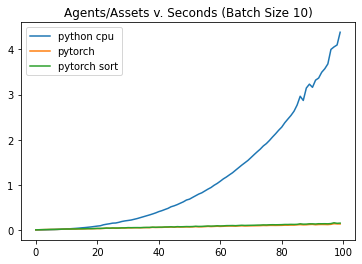

In [37]:
import matplotlib.pyplot as plt
plt.plot(cpu_times[::-1], label="python cpu")
plt.plot(cuda_times[::-1], label="pytorch")
plt.plot(cuda_sort_times[::-1], label="pytorch sort")
plt.title("Agents/Assets v. Seconds (Batch Size 10)")
plt.legend()

plt.show()

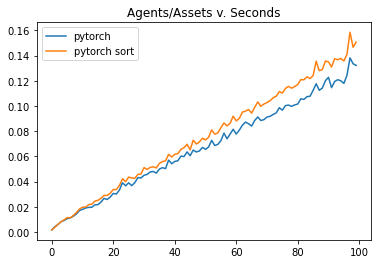

In [38]:
plt.plot(cuda_times[::-1], label="pytorch")
plt.plot(cuda_sort_times[::-1], label="pytorch sort")
plt.title("Agents/Assets v. Seconds")
plt.legend()

plt.show()

In [35]:
cur_alloc = 10000*np.ones((1, n_orders_bid // num_assets, num_assets))
cur_cash = np.zeros((1, n_orders_bid // num_assets))



In [36]:
order_books[-1]

[{'asset': 0,
  'side': 'bid',
  'vol': 67,
  'price': 85.75687677196541,
  'id': 0,
  'instr': 'leverage'},
 {'asset': 1,
  'side': 'bid',
  'vol': 75,
  'price': 88.94581491683304,
  'id': 0,
  'instr': 'leverage'},
 {'asset': 2,
  'side': 'bid',
  'vol': 93,
  'price': 68.94155137246898,
  'id': 0,
  'instr': 'credit'},
 {'asset': 3,
  'side': 'bid',
  'vol': 88,
  'price': 82.82738098452694,
  'id': 0,
  'instr': 'cash'},
 {'asset': 4,
  'side': 'bid',
  'vol': 66,
  'price': 12.824223925434586,
  'id': 0,
  'instr': 'cash'},
 {'asset': 0,
  'side': 'bid',
  'vol': 11,
  'price': 26.201170830365818,
  'id': 1,
  'instr': 'leverage'},
 {'asset': 1,
  'side': 'bid',
  'vol': 43,
  'price': 54.731683146710495,
  'id': 1,
  'instr': 'leverage'},
 {'asset': 2,
  'side': 'bid',
  'vol': 54,
  'price': 25.291157423731836,
  'id': 1,
  'instr': 'credit'},
 {'asset': 3,
  'side': 'bid',
  'vol': 16,
  'price': 22.998322688153984,
  'id': 1,
  'instr': 'credit'},
 {'asset': 4,
  'side': 'bid

In [37]:
len(tradelist__lk)

50

In [38]:
info

[]

In [39]:
for t in tradelist__lk:
    cur_alloc[0][t['id']][t['asset']] += t['cleared_vol']
    cur_cash[0][t['id']] += t['cleared_cash']

In [40]:
cur_alloc

array([[[10014., 10074., 10053., 10088., 10000.],
        [ 9988.,  9909.,  9969.,  9953.,  9979.],
        [10000., 10059.,  9965.,  9988., 10000.],
        [ 9984.,  9958., 10074.,  9946., 10060.],
        [10014., 10000.,  9939., 10025.,  9961.]]])

In [41]:
cur_cash

array([[-19063.85246865,  15362.75507039,  -1710.56478309,
           142.6288047 ,   5269.03337664]])

In [42]:
env.cur_alloc[-1]

tensor([[10014., 10074., 10053., 10088., 10000.],
        [ 9988.,  9909.,  9969.,  9953.,  9979.],
        [10000., 10059.,  9965.,  9988., 10000.],
        [ 9984.,  9958., 10074.,  9946., 10060.],
        [10014., 10000.,  9939., 10025.,  9961.]], device='cuda:0')

In [43]:
env.cash[-1]

tensor([-19063.8535,  15362.7549,  -1710.5649,    142.6283,   5269.0332],
       device='cuda:0')

In [45]:
env2.cur_alloc[-1]

tensor([[10014., 10074., 10053., 10088., 10000.],
        [ 9988.,  9909.,  9969.,  9953.,  9979.],
        [10000., 10059.,  9965.,  9988., 10000.],
        [ 9984.,  9958., 10074.,  9946., 10060.],
        [10014., 10000.,  9939., 10025.,  9961.]], device='cuda:0')

In [46]:
env2.cash[-1]

tensor([-19063.8535,  15362.7549,  -1710.5649,    142.6283,   5269.0332],
       device='cuda:0')